# V928 Tau - Paper Plots

In this notebook we produce all the figures that can be seen in the paper (van Dam et al. 2020 under review). No analysis takes place here, just the plots themselves.

In [2]:
# import standard packages
import os
import emcee
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# import own packages
from Code import mcmc, eclipse
from Code import period_analysis as pa
from Code import orbital_analysis as oa
from Code import ground_variation as gv
from Code import stellar_variation as sv

%matplotlib inline

### Figure 2 - Eclipse (Blended and De-blended)

This is a plot of the K2 eclipse after removing the stellar variations. It shows the blended light curve and the dilution corrected light curve (doubling the fluctuations about 1) based on the assumption that V928 Tau A and B are identical. The low flux outlier due to a thruster firing is shown and overlaid with a red X.

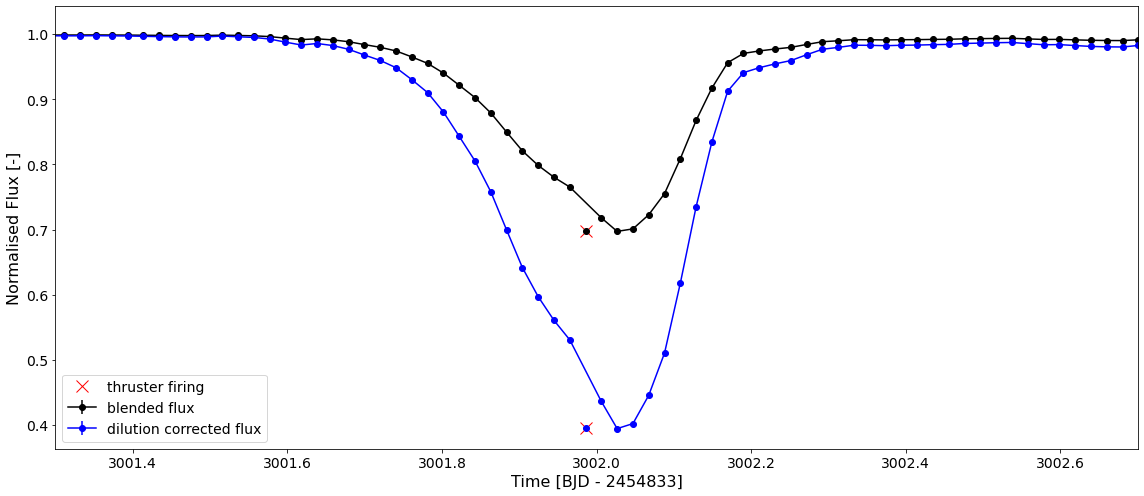

In [3]:
k2_time, k2_flux, k2_fluxc, k2_error = np.loadtxt('data/photometry/eclipse_lightcurve.txt').T

ind = 695
tt = k2_time[ind]
ff = k2_flux[ind]
fc = k2_fluxc[ind]
ee = k2_error[ind]

k2_time  = np.delete(k2_time, ind)
k2_flux  = np.delete(k2_flux, ind)
k2_fluxc = np.delete(k2_fluxc, ind)
k2_error = np.delete(k2_error, ind)

plt.figure(figsize=(16, 7))
plt.xlabel('Time [BJD - 2454833]', fontsize=16)
plt.ylabel('Normalised Flux [-]', fontsize=16)
plt.errorbar(k2_time, k2_flux, k2_error, marker='o', color='k', label='blended flux')
plt.errorbar(tt, ff, ee, marker='o', color='k')
plt.plot(tt, ff, marker='x', color='r', ms=12)
plt.errorbar(k2_time, k2_fluxc, k2_error, marker='o', color='b', label='dilution corrected flux')
plt.errorbar(tt, fc, ee, marker='o', color='b')
plt.plot(tt, fc, marker='x', color='r', ls='', ms=12, label='thruster firing')
plt.gca().tick_params(labelsize=14)
plt.xlim(3001.3, 3002.7)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('plots/paper/eclipse.png')
plt.show()

## Figure 3 - All the Photometry

This shows all the photometry we could find and collect for V928 Tau from ASAS, ASAS-SN, ATLAS, CRTS, K2, KELT, PTF, SWASP and ZTF, with contributions from amateur astronomers Sjoerd Dufoer (DFS), Franz-Josef Hambsch (HMB), Tonny Vanmunster (VMT) and the Astrolab Iris Team (Franky Dubois, Siegfried Vanaverbeke, Steve Rau and Ludwig Logie).

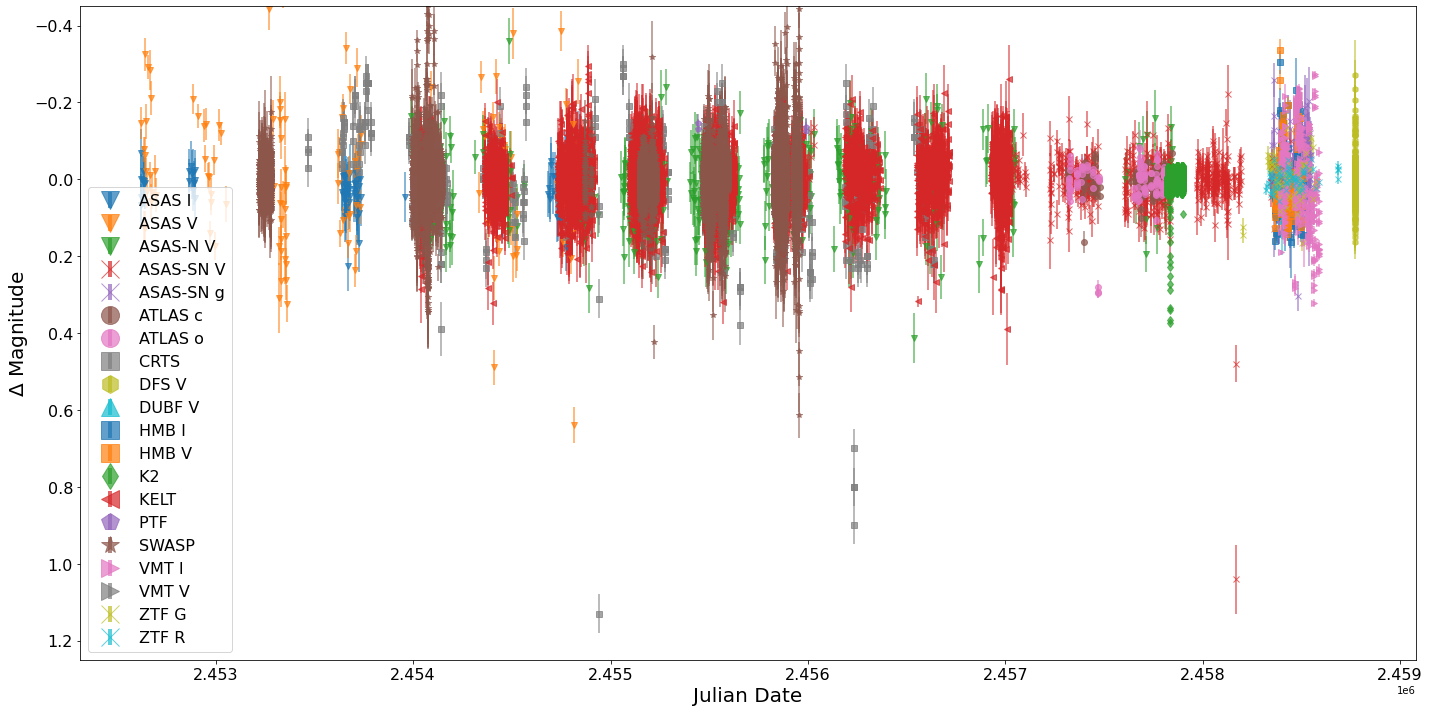

In [4]:
# load data
times, mags, errors, telescopes = gv.load_survey_data('data/photometry/all_data.txt')

# plot and save
gv.plot_all(times, mags, errors, telescopes, savename='plots/paper/all_photometry.png')

## Figure 4 - Interesting Periods

After performing a high resolution period folding grid and reviewing the plots by hand six interesting periods were found that suggest periodicity they are plotted here.

In [5]:
# get k2_time0
for i, tel in enumerate(telescopes):
    if 'K2' in tel:
        k2_ind = i
k2_time0 = times[k2_ind][0]

# remove stellar variations from data
pb_sv = np.load('models/best_fits/stellar_variation.npy')
mags_corr = []
for time, mag in zip(times, mags):
    stellar_var = gv.ground_stellar_variation_model(pb_sv, time, k2_time0)
    mags_corr.append(mag - stellar_var)

# prepare the parameters
k2_tl = 681-14
k2_tu = 710+14

ground_times  = []
ground_mags   = []
ground_errors = []
ground_tels   = []

for time, mag, error, tel in zip(times, mags, errors, telescopes):
    if 'K2' in tel:
        k2_times  = time
        k2_mags   = mag
        k2_errors = error
    else:
        ground_times.append(time)
        ground_mags.append(mag)
        ground_errors.append(error)
        ground_tels.append(tel)
        
        
k2_pars = (k2_times, k2_mags, k2_errors)
gr_pars = (ground_times, ground_mags, ground_errors)

AttributeError: module 'Code.ground_variation' has no attribute 'ground_stellar_variation_model'

In [ ]:
P_int = np.array([[178.050, 201.200, 204.166], [341.792, 343.766, 685.192]])

# plot parameters
grid = (8, 10)
mrkrs = ['v','x','o','s','h','^','s','d','<','p','*','>','x']
locs  = [0,0,0,1,1,2,2,3,4,5,6,6,7,8,9,10,11,11,12,12]

# create plot
fig = plt.figure(figsize=(16, 10))
for i in range(2):
    for j in range(3):
        # determine position on the grid
        pos_phot = (i * 4, 3*j)
        pos_res  = (i * 4 + 3, 3*j)
        # create axes
        ax_phot = plt.subplot2grid(grid, pos_phot, colspan=3, rowspan=3)
        ax_res  = plt.subplot2grid(grid, pos_res, colspan=3, rowspan=1, sharex=ax_phot)
        ax_res.axhline(y=0, color='k', ls=':')
        ax_phot.tick_params(labelsize=14)
        ax_res.tick_params(labelsize=14)
        # only ylabel on the left edge otherwise remove yticklabels
        if j == 0 :
            ax_phot.set_ylabel('$\Delta$ Magnitude', fontsize=16)
            ax_res.set_ylabel('Residuals', fontsize=16)
        else:
            ax_phot.set_yticklabels([])
            ax_res.set_yticklabels([])
        # only xlabel on the bottom middle plot
        if i == 1 and j == 1:
            ax_res.set_xlabel('Phase', fontsize=16)
        # no phase labels
        ax_phot.set_xticklabels([])
        ax_res.set_xticklabels([])
        # get the period and the title
        period = P_int[i, j]
        ax_phot.set_title('Period = %.3f days' % period, y=0.9, fontsize=16)
        # calculate the data
        plot_data, _, _, _, _ = pa.prepare_data(period, *k2_pars, *gr_pars, k2_tl, k2_tu, 10)
        k2p, k2m, k2e, grp, grm, gre, gri = plot_data
        # plot K2 data
        ax_phot.errorbar(k2p, k2m, yerr=k2e, fmt='d', color='C2', label='K2')
        # plot the ground data
        lbl = 'Interpolated'
        x = 0
        for p, m, e, im, tel in zip(grp, grm, gre, gri, ground_tels):
            c = 'C%i' % (x % 10)
            mrk = mrkrs[locs[x]]
            x += 1
            # skip K2 index
            if x == k2_ind:
                x += 1
            if len(p) == 0:
                continue
            ax_phot.errorbar(p, im, yerr=0, fmt='.', color='m', label=lbl)
            ax_phot.errorbar(p, m,  yerr=e, fmt=mrk, color=c, label=tel)
            ax_res.errorbar(p, im - m, yerr=e, fmt=mrk, color=c)
            lbl = None # don't overlabel interpolated data
        # set y lims on both plots
        ax_phot.set_ylim(0.45, -0.18)
        ax_res.set_ylim(0.25, -0.25)
# adding a single legend
leg_elements = []
for x, tel in enumerate(telescopes):
    c = 'C%i'% (x%10)
    leg_elements.append(Line2D([-10],[-10], ls='', color=c, marker=mrkrs[locs[x]], label=tel))
leg_elements.append(Line2D([-10],[-10],ls='', marker='.', color='m', label='Interpolated'))
fig.legend(handles=leg_elements, loc='center left',bbox_to_anchor=[0.88,0.5], fontsize=14)
# remove white space
plt.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)
plt.savefig('plots/paper/interesting_periods.png')
plt.show()

## Figure 7 - Stellar Variations

This plot shows the results of the MCMC optimisation on the stellar variations plot.

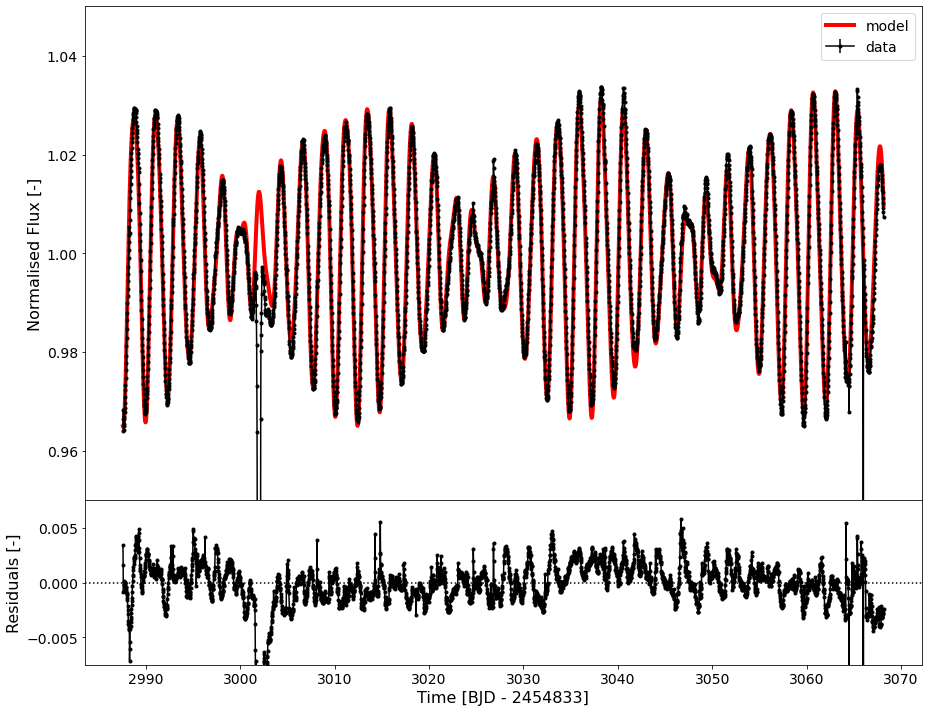

In [7]:
stellar_variation = lambda P, time: sv.line(time, *P[0:2], time[0]) + sv.sines(time, P[2:6], P[6:10], P[10:14], time[0])

time_sv, flux_sv, error_sv = np.loadtxt('data/photometry/everest_lightcurve.txt').T
Pb_sv = np.load('models/best_fits/stellar_variation.npy')
_ = mcmc.plot_models(time_sv, flux_sv, error_sv, [stellar_variation], [Pb_sv], ['model'], 
                 plot_lims=(0.95,1.05), residual_lims=(-0.0075,0.0075), 
                 savename='plots/paper/stellar_variation_model.png')

## Figure 8 - Eclipse Models

This figure shows all the eclipse models (by showing samples of the walkers) for all the different solutions found.

In [8]:
time_ecl, _, flux_ecl, error_ecl = eclipse.load_data('data/photometry/eclipse_lightcurve.txt')

### Opaque Disk

In [9]:
# model functions
pack_od      = lambda rd, b, inc, tilt, vel, dx: (rd, 0., b, inc, tilt, vel, dx, 1., 0.)
opaque_disk  = lambda P, time: eclipse.disk_model(pack_od(*P), time)
opaque_prior = lambda P: eclipse.disk_prior(pack_od(*P))

# model labels
lbls_od = ['disk radius', 'impact parameter', 'inclination', 'tilt', 'velocity', 'time shift']

# load opaque sampler
be_od = 'models/mcmc_backends/opaque_disk.h5'
BE_od = emcee.backends.HDFBackend(be_od)
args_od = (time_ecl, flux_ecl, error_ecl, opaque_disk, opaque_prior)
sampler_od = emcee.EnsembleSampler(1000, 6, mcmc.lnprob, args=args_od, backend=BE_od)

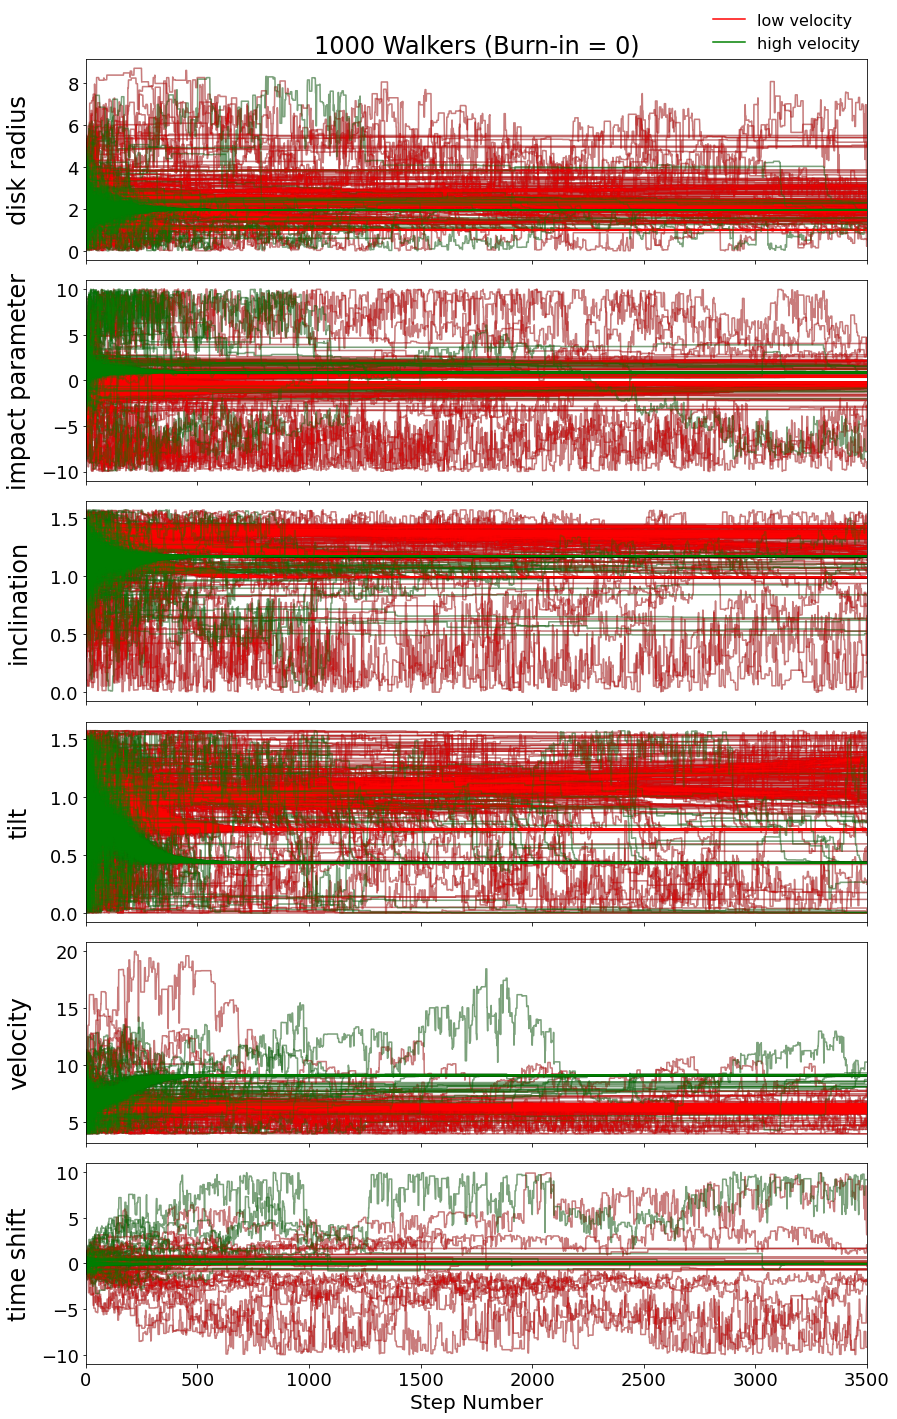

In [10]:
# extracting the low and high velocity solutions for the opaque disk
vel_names_od = ['low velocity', 'high velocity']
lvel_od, hvel_od = mcmc.extract_solutions(sampler_od, [4, 4], [(0, 8), (8, 20)], 0, lbls_od, vel_names_od)

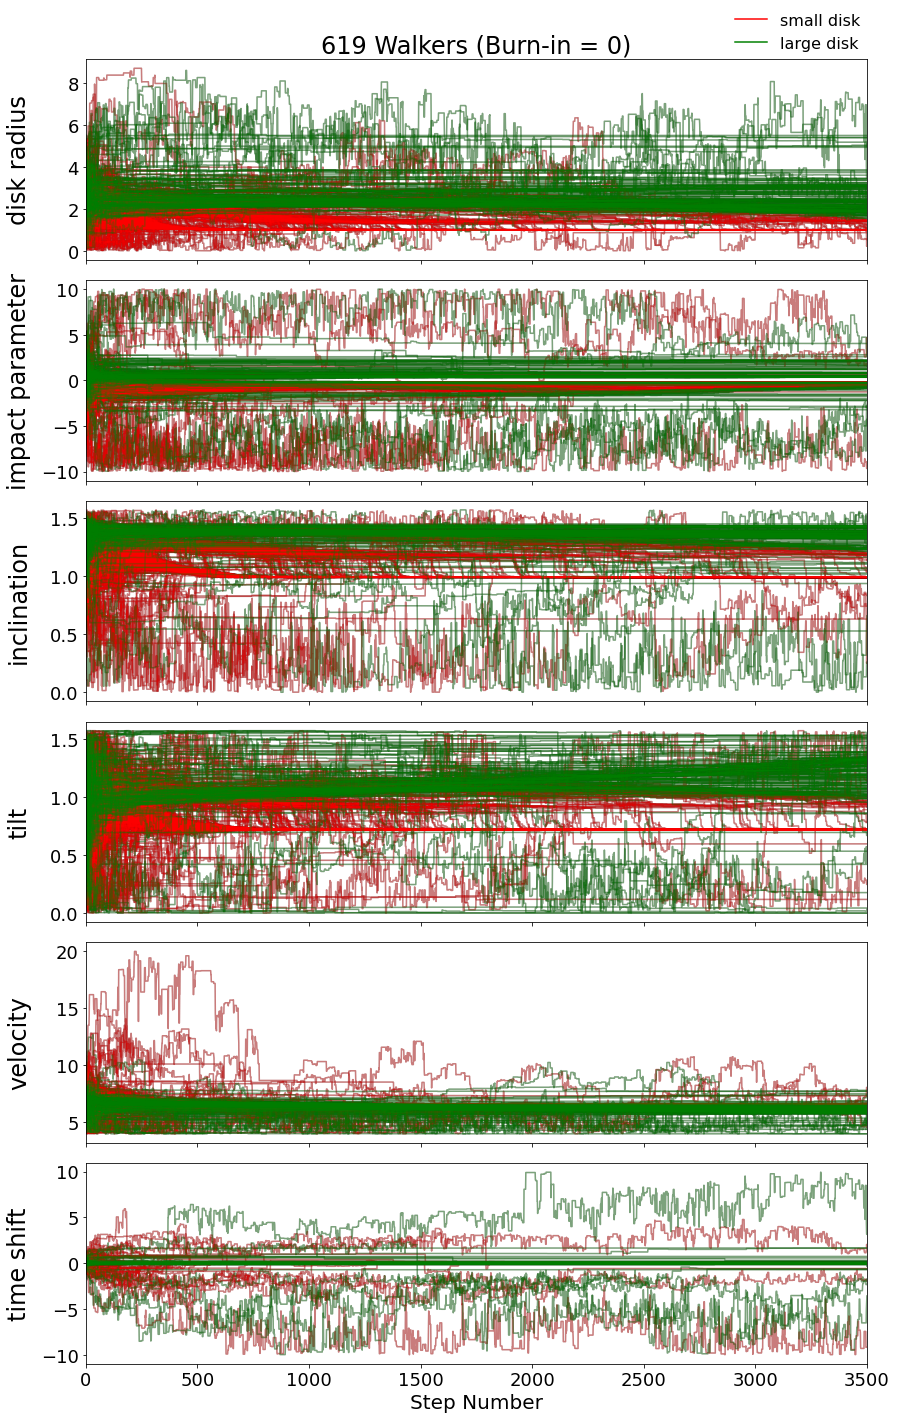

In [11]:
# extract low velocity disk radii solutions for the opaque disk
dr_names_od = ['small disk', 'large disk']
ldr_od, hdr_od = mcmc.extract_solutions(lvel_od, [0, 0], [(0, 1.5), (1.5, 20)], 0, lbls_od, dr_names_od)

In [12]:
print(hvel_od.shape)
print(ldr_od.shape)
# determining the burn-in's
cut_hvel_od = 500
cut_ldr_od  = 1000

(3500, 381, 6)
(3500, 472, 6)


### Fuzzy Disk

In [13]:
# model functions
fuzzy_disk  = eclipse.disk_model
fuzzy_prior = eclipse.disk_prior

# model labels
lbls_fd = ['disk radius', 'edge thickness', 'impact parameter', 'inclination', 'tilt', 'velocity',
           'time shift', 'disk opacity', 'edge opacity']

# load fuzzy sampler
be_fd = 'models/mcmc_backends/fuzzy_disk_new.h5'
BE_fd = emcee.backends.HDFBackend(be_fd)
mcmc_args_fd = (time_ecl, flux_ecl, error_ecl, fuzzy_disk, fuzzy_prior)
sampler_fd = emcee.EnsembleSampler(1000, 9, mcmc.lnprob, args=mcmc_args_fd, backend=BE_fd)

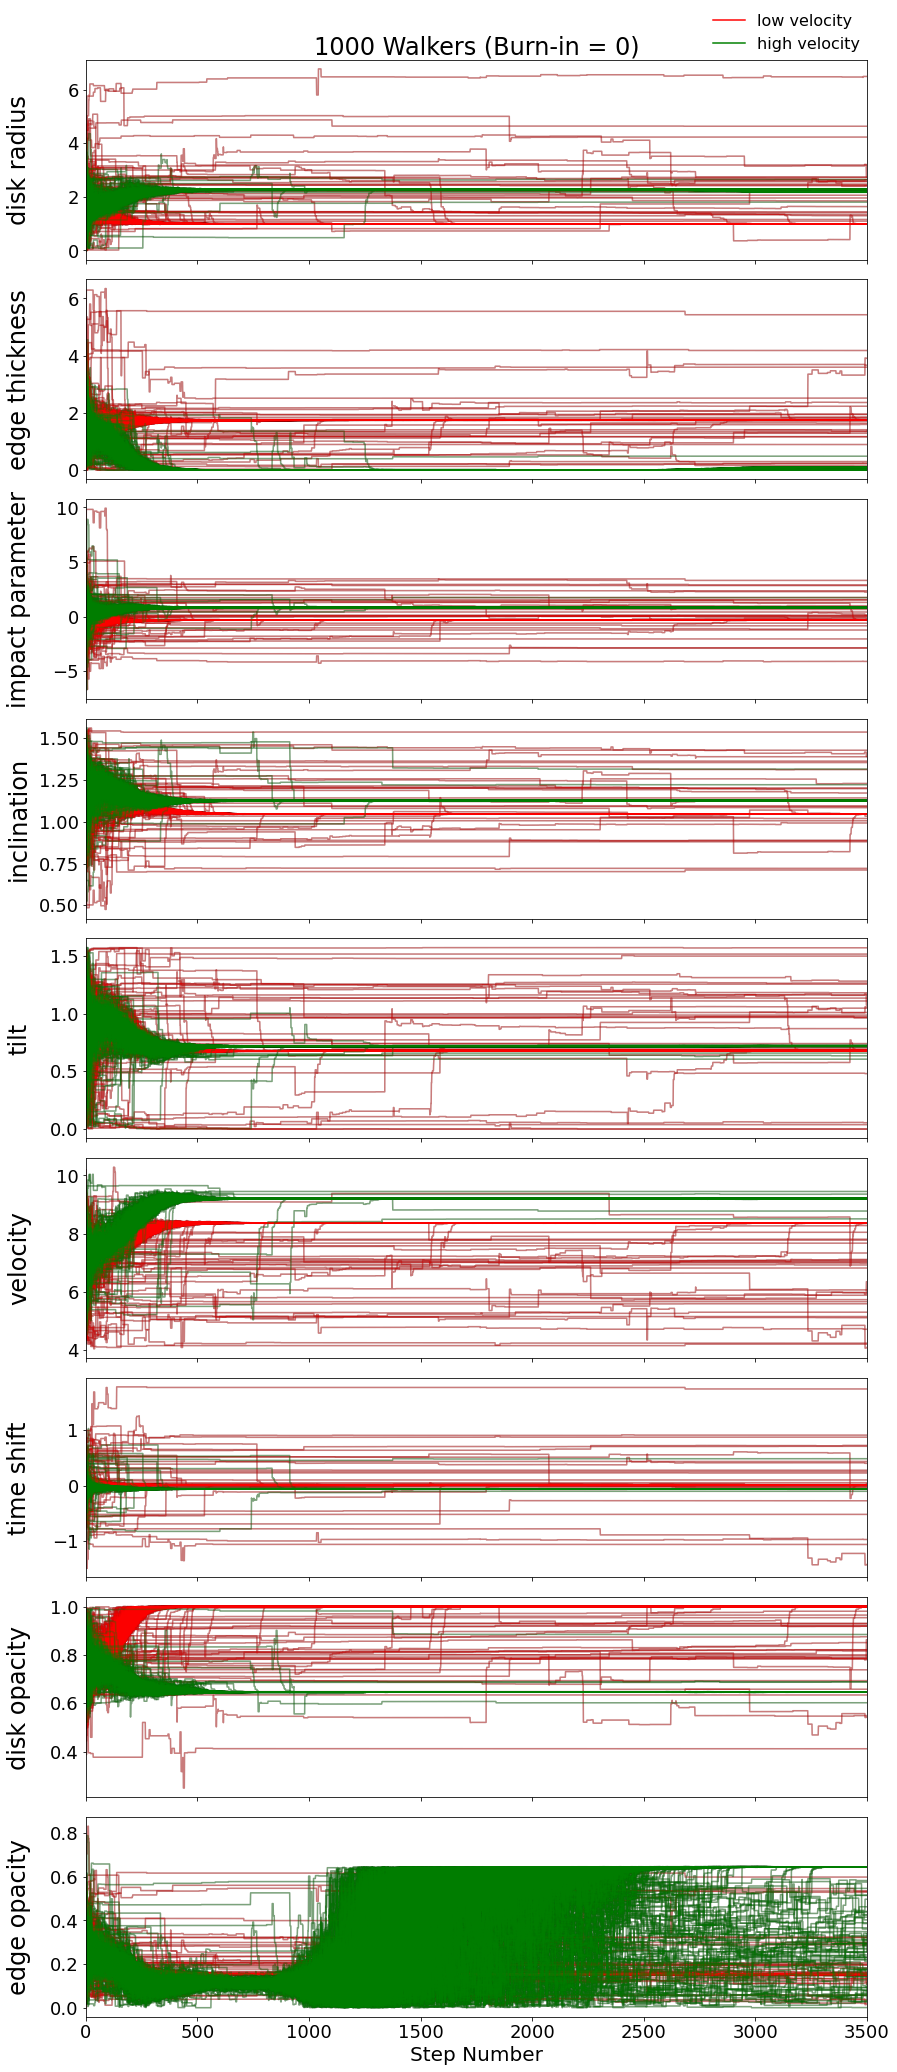

In [14]:
# extracting disk opacity radius for the fuzzy disk
vel_names_fd = ['low velocity', 'high velocity']
lvel_fd, hvel_fd = mcmc.extract_solutions(sampler_fd, [5, 5], [(0, 8.5), (8.5, 20)], 0, lbls_fd, vel_names_fd)

In [15]:
print(hvel_fd.shape)
print(lvel_fd.shape)
# determine burn-in for the fuzzy disk
cut_hvel_fd = 2500
cut_lvel_fd = 1000

(3500, 446, 9)
(3500, 554, 9)


### Make the Actual Plot

100%|██████████| 500/500 [01:34<00:00,  5.30it/s]


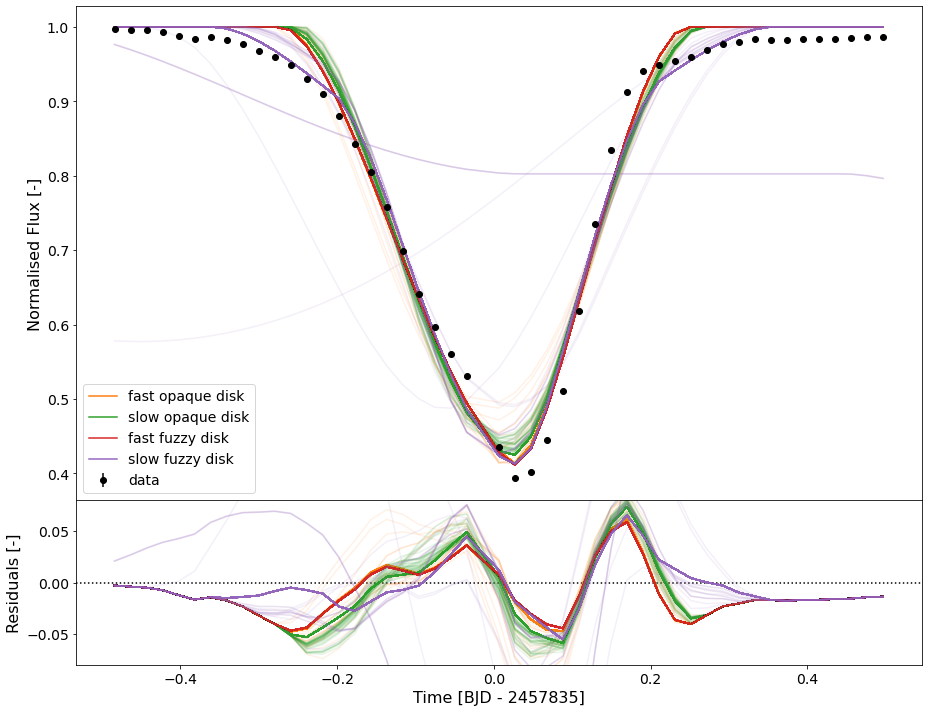

In [17]:
mods = [opaque_disk, opaque_disk, fuzzy_disk, fuzzy_disk]
smps = [hvel_od, ldr_od, hvel_fd, lvel_fd]
lbls = ['fast opaque disk', 'slow opaque disk', 'fast fuzzy disk', 'slow fuzzy disk']
cuts = [cut_hvel_od, cut_ldr_od, cut_hvel_fd, cut_lvel_fd]
_ = mcmc.plot_samples(time_ecl, flux_ecl, error_ecl, mods, smps, lbls, cuts, 500, dt=3002, 
                      residual_lims=(-0.08,0.08), savename='plots/paper/eclipse_models.png')

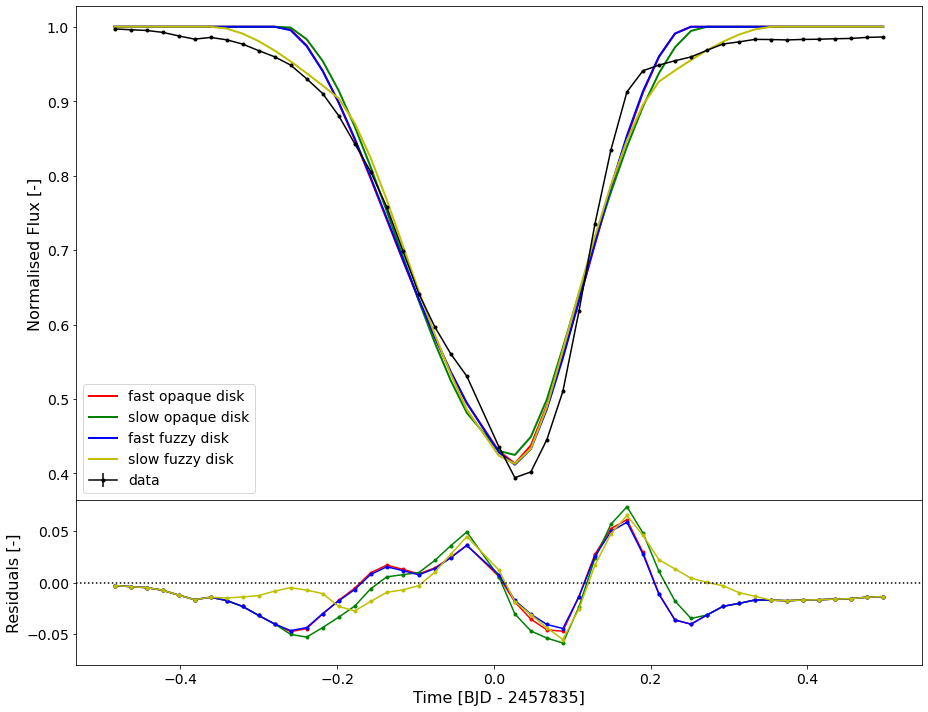

In [18]:
pbs = [np.load('models/best_fits/opaque_disk_high_velocity.npy'), 
       np.load('models/best_fits/opaque_disk_low_velocity_small_disk.npy'),
       np.load('models/best_fits/fuzzy_high_vel_disk.npy'),
       np.load('models/best_fits/fuzzy_low_vel_disk.npy')]

chi2s = mcmc.plot_models(time_ecl, flux_ecl, error_ecl, mods, pbs, lbls, dt=3002, residual_lims=(-0.08, 0.08), 
                            lw=2, savename='plots/paper/eclipse_models_best_fits.png')

## Figure 9 - Parameter Map Subplots

We determined that the only eclipse model it makes sense to take into consideration for these plots is the slow opaque disk, otherwise almost all the parameter space is whited out and you need a very large companion ($M_p > 70\,M_\mathrm{jup}$). We also chose to look at the magnetic models instead of the standard models for both V928 Tau A and B.

In [30]:
# V928 Tau A
M1 = 0.700 * u.Msun
R1  = 1.376 * u.Rsun

# V928 Tau B
M2 = 0.700 * u.Msun
R2  = 1.296 * u.Rsun

# V928 Tau separation
a_bin = 32 * u.au

# compound lists
Ms = [M1, M2]
Rs = [R1, R2]
host_lbls = ['A (magnetic)', 'B (magnetic)']

# load parameters
pb = np.load('models/best_fits/opaque_disk_low_velocity_small_disk.npy')
saveroot = 'plots/paper/parameters/'
if not os.path.exists(saveroot):
    os.mkdir(saveroot)

rdisk, b, inc, tilt, vt, dt = pb
    
# calculate total size
rtot = rdisk

# transform to SI units
r1 = (rtot * R1).to(u.au)
r2 = (rtot * R2).to(u.au)
rs = [r1, r2]

# convert to km/s
v1 = (vt * R1 / u.day).to(u.km / u.s)
v2 = (vt * R2 / u.day).to(u.km / u.s)
vs = [v1, v2]

# maximum from above plots
Mp_minn = 0 * u.Mjup
Mp_maxn = 80 * u.Mjup
P_minn = 0 * u.day
P_maxn = 1000 * u.day

# new resolution grid
Mpn = np.linspace(Mp_minn, Mp_maxn, 10 * int((Mp_maxn - Mp_minn).value) + 1)
Pn  = np.linspace(P_minn, P_maxn, 10 * int((P_maxn - P_minn).value) + 1)

# get the parameters
en   = []
rpn  = []
rapn = []
rhn  = []

# populate lists
for M, vp in zip(Ms, vs):
    e, rp, rap, rh = oa.get_parameters(M, Mpn, Pn, vp)
    # append
    en.append(e)
    rpn.append(rp)
    rapn.append(rap)
    rhn.append(rh)
    
# determine r_ap and r_Hill masks
rap_maskn = []
rh_maskn  = []
for rap, r, rh in zip(rapn, rs, rhn):
    # define
    rap_mask = rap.value <= 3.2
    rh_mask  = r.value <= 0.3 * rh.value
    # append
    rap_maskn.append(rap_mask)
    rh_maskn.append(rh_mask)
    
# save labels
savebases = ['%s_Amag.png', '%s_Bmag.png']

# plot all the different versions of one parameter to see the extent of P and Mp
param_lbls = ['$%smag, A}$', '$%smag, B}$']

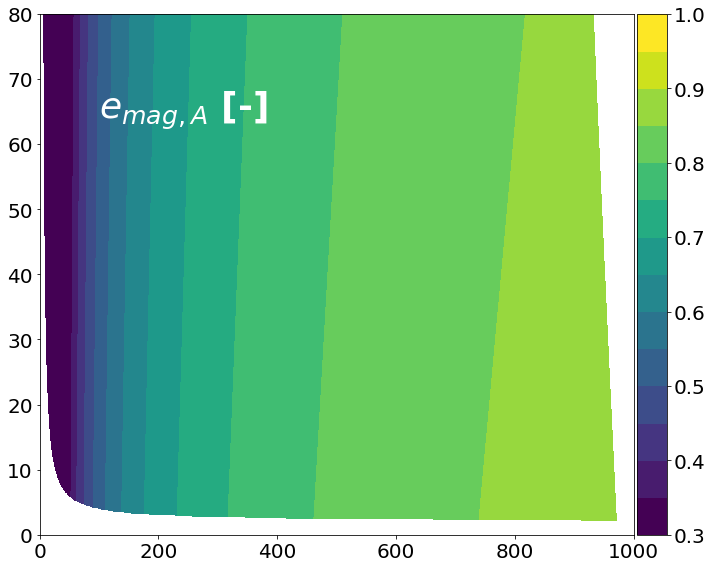

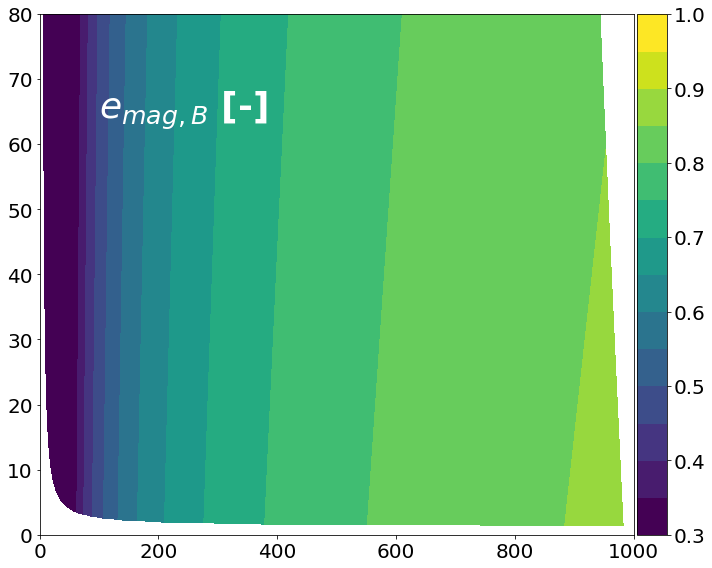

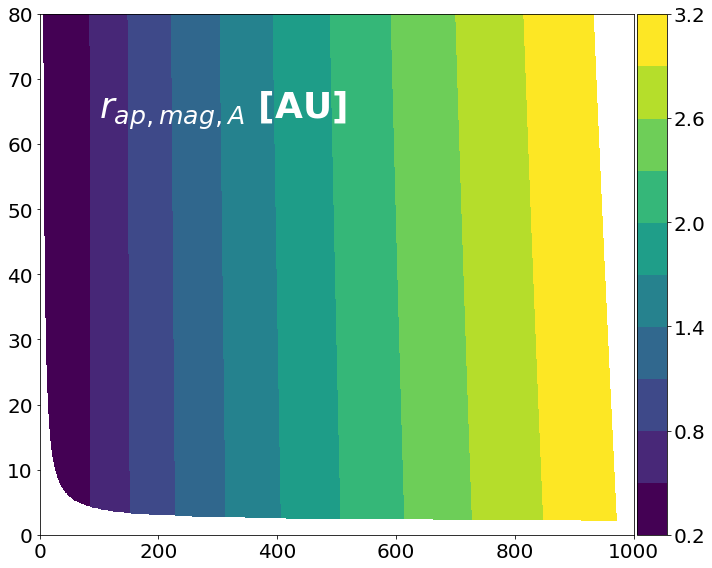

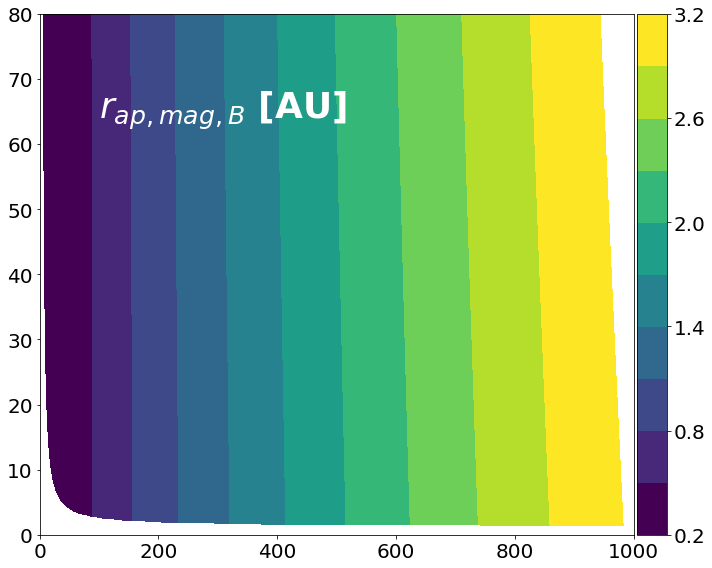

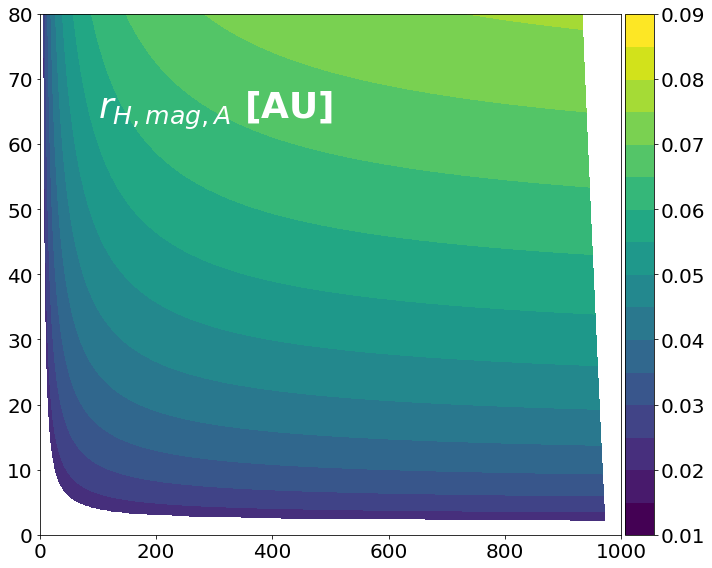

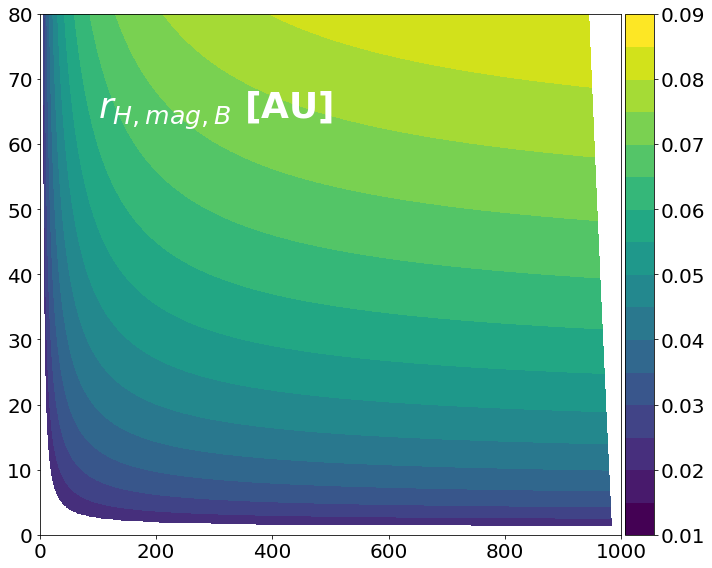

In [31]:
# eccentricity
for e, lbl, rap_m, rh_m, sb in zip(en, param_lbls, rap_maskn, rh_maskn, savebases):
    save = saveroot + sb % 'e'
    param = lbl % 'e_{'
    oa.plot_parameter(Pn, Mpn, e, param, rap_mask=rap_m, rh_mask=rh_m, vmin=0.3, vmax=1, 
                      lvls=14, tick_num=8, savename=save, title_color='w')

# apastron passage
for rap, lbl, rap_m, rh_m, sb in zip(rapn, param_lbls, rap_maskn, rh_maskn, savebases):
    savename = saveroot + sb % 'rap'
    param = lbl % 'r_{ap, '
    oa.plot_parameter(Pn, Mpn, rap, param, rap_mask=rap_m, rh_mask=rh_m, vmin=0.2, vmax=3.2,
                      savename=savename, title_color='w')

# hill radius
for rh, lbl, rap_m, rh_m, sb in zip(rhn, param_lbls, rap_maskn, rh_maskn, savebases):
    save = saveroot + sb % 'rh'
    param = lbl % 'r_{H, '
    oa.plot_parameter(Pn, Mpn, rh, param, rap_mask=rap_m, rh_mask=rh_m, vmin=0.01, vmax=0.09, 
                      lvls=16, tick_num=9, savename=save, title_color='w')